<a href="https://colab.research.google.com/github/akashasd/project/blob/main/loanprediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import pandas as pd
import numpy as np
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

import shap
import matplotlib.pyplot as plt

# 2) Load dataset
df = pd.read_csv("/content/archive (3).zip")  # change path if your file name is different

# 3) Features & Target
X = df.drop("loan_status", axis=1)
y = df["loan_status"]

# 4) Identify categorical vs numerical
cat_features = X.select_dtypes(include=['object']).columns.tolist()
num_features = X.select_dtypes(include=['int64','float64']).columns.tolist()

# 5) Preprocessing
preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown='ignore'), cat_features),
    ("num", StandardScaler(), num_features)
])

# 6) Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 7) SMOTE balancing
smote = SMOTE(random_state=42)

# 8) Base models with SMOTE inside pipelines

# XGBoost Classifier (strong gradient boosting)
xgb_model = ImbPipeline([
    ("preprocess", preprocessor),
    ("smote", smote),
    ("xgb", XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        n_estimators=600,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.85,
        colsample_bytree=0.85,
        random_state=42
    ))
])

# Random Forest
rf_model = ImbPipeline([
    ("preprocess", preprocessor),
    ("smote", smote),
    ("rf", RandomForestClassifier(
        n_estimators=600,
        random_state=42,
        class_weight="balanced"
    ))
])

# Logistic Regression
lr_model = ImbPipeline([
    ("preprocess", preprocessor),
    ("smote", smote),
    ("lr", LogisticRegression(
        max_iter=5000,
        solver="saga",
        class_weight="balanced"
    ))
])

# 9) Stacking Ensemble
stack_model = StackingClassifier(
    estimators=[
        ('xgb', xgb_model),
        ('rf', rf_model),
        ('lr', lr_model)
    ],
    final_estimator=LogisticRegression(max_iter=5000, solver="saga"),
    cv=5,
    stack_method="predict_proba"
)

# 10) Train stacking model
stack_model.fit(X_train, y_train)

# 11) Evaluate
y_proba = stack_model.predict_proba(X_test)[:,1]
threshold = 0.5  # you can optimize this for recall/precision trade-off
y_pred = (y_proba > threshold).astype(int)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# 12) SHAP Explainability for XGBoost
# Access the fitted XGBoost model from inside the stacking classifier
fitted_xgb_pipeline = stack_model.named_estimators_['xgb']
fitted_preprocessor = fitted_xgb_pipeline.named_steps['preprocess']

# Transform the test set with the fitted preprocessor
X_test_transformed = fitted_preprocessor.transform(X_test)

# Create a SHAP explainer using the fitted XGBoost model's predict_proba
explainer = shap.Explainer(fitted_xgb_pipeline.named_steps['xgb'].predict_proba)

# Compute SHAP values on the transformed test set
shap_values = explainer(X_test_transformed)

# Plot the SHAP summary
shap.summary_plot(shap_values, X_test_transformed)
# Save model and feature names
joblib.dump(model, "ensemeble_model.pkl")




Accuracy: 0.935
ROC-AUC: 0.9776803571428571
Confusion Matrix:
 [[6784  216]
 [ 369 1631]]

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.97      0.96      7000
           1       0.88      0.82      0.85      2000

    accuracy                           0.94      9000
   macro avg       0.92      0.89      0.90      9000
weighted avg       0.93      0.94      0.93      9000



ValueError: masker cannot be None.

Accuracy: 0.935
ROC-AUC: 0.9776811428571428
Confusion Matrix:
 [[6784  216]
 [ 369 1631]]

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.97      0.96      7000
           1       0.88      0.82      0.85      2000

    accuracy                           0.94      9000
   macro avg       0.92      0.89      0.90      9000
weighted avg       0.93      0.94      0.93      9000



PermutationExplainer explainer: 9001it [1:25:51,  1.75it/s]
/tmp/ipython-input-2393917205.py:126: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_transformed)
/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.py:723: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(
/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.py:743: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(


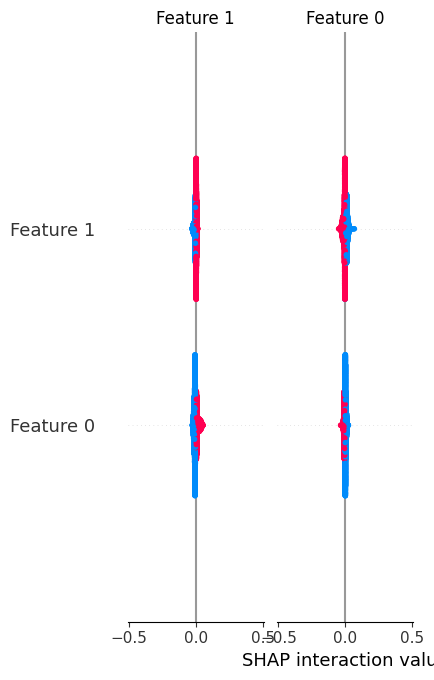

['ensemeble_model.pkl']

In [ ]:
import pandas as pd
import numpy as np
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

import shap
import matplotlib.pyplot as plt

# 2) Load dataset
df = pd.read_csv("/content/archive (3).zip")  # change path if your file name is different

# 3) Features & Target
X = df.drop("loan_status", axis=1)
y = df["loan_status"]

# 4) Identify categorical vs numerical
cat_features = X.select_dtypes(include=['object']).columns.tolist()
num_features = X.select_dtypes(include=['int64','float64']).columns.tolist()

# 5) Preprocessing
preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown='ignore'), cat_features),
    ("num", StandardScaler(), num_features)
])

# 6) Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 7) SMOTE balancing
smote = SMOTE(random_state=42)

# 8) Base models with SMOTE inside pipelines

# XGBoost Classifier (strong gradient boosting)
xgb_model = ImbPipeline([
    ("preprocess", preprocessor),
    ("smote", smote),
    ("xgb", XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        n_estimators=600,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.85,
        colsample_bytree=0.85,
        random_state=42
    ))
])

# Random Forest
rf_model = ImbPipeline([
    ("preprocess", preprocessor),
    ("smote", smote),
    ("rf", RandomForestClassifier(
        n_estimators=600,
        random_state=42,
        class_weight="balanced"
    ))
])

# Logistic Regression
lr_model = ImbPipeline([
    ("preprocess", preprocessor),
    ("smote", smote),
    ("lr", LogisticRegression(
        max_iter=5000,
        solver="saga",
        class_weight="balanced"
    ))
])

# 9) Stacking Ensemble
stack_model = StackingClassifier(
    estimators=[
        ('xgb', xgb_model),
        ('rf', rf_model),
        ('lr', lr_model)
    ],
    final_estimator=LogisticRegression(max_iter=5000, solver="saga"),
    cv=5,
    stack_method="predict_proba"
)

# 10) Train stacking model
stack_model.fit(X_train, y_train)

# 11) Evaluate
y_proba = stack_model.predict_proba(X_test)[:,1]
threshold = 0.5  # you can optimize this for recall/precision trade-off
y_pred = (y_proba > threshold).astype(int)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# 12) SHAP Explainability for XGBoost
# Access the fitted XGBoost model from inside the stacking classifier
fitted_xgb_pipeline = stack_model.named_estimators_['xgb']
fitted_preprocessor = fitted_xgb_pipeline.named_steps['preprocess']

# Transform the test set with the fitted preprocessor
X_test_transformed = fitted_preprocessor.transform(X_test)

# Create a SHAP explainer using the fitted XGBoost model's predict_proba and the transformed test set as masker
explainer = shap.Explainer(fitted_xgb_pipeline.named_steps['xgb'].predict_proba, masker=X_test_transformed)

# Compute SHAP values on the transformed test set
shap_values = explainer(X_test_transformed)

# Plot the SHAP summary
shap.summary_plot(shap_values, X_test_transformed)
# Save model and feature names
joblib.dump(stack_model, "ensemeble_model.pkl")

PermutationExplainer explainer: 9001it [1:24:23,  1.77it/s]


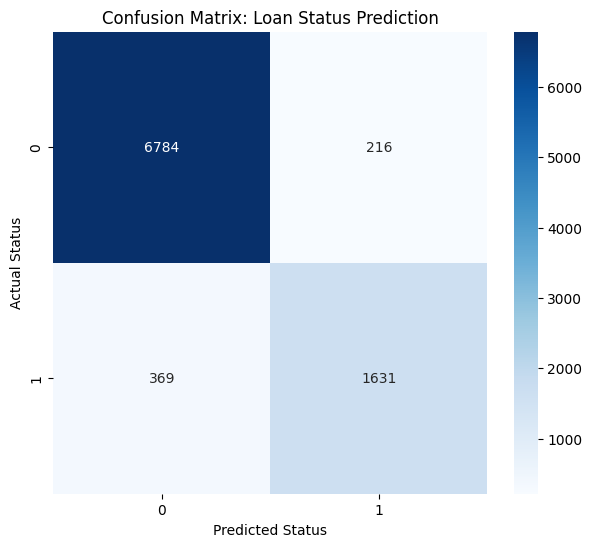

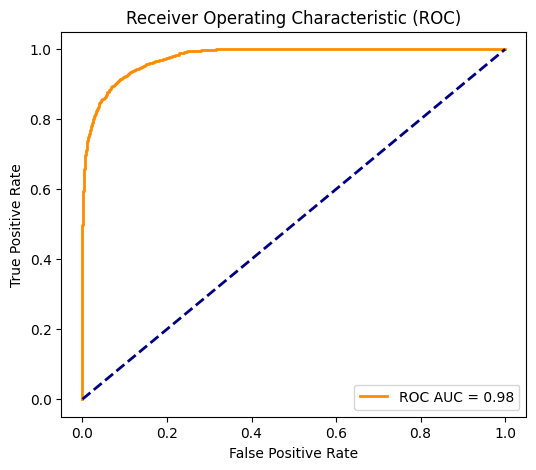

/tmp/ipython-input-512449683.py:159: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_summary_values, X_test_transformed, feature_names=all_feature_names, show=False)
/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.py:723: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(
/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.py:743: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(


<Figure size 640x480 with 0 Axes>

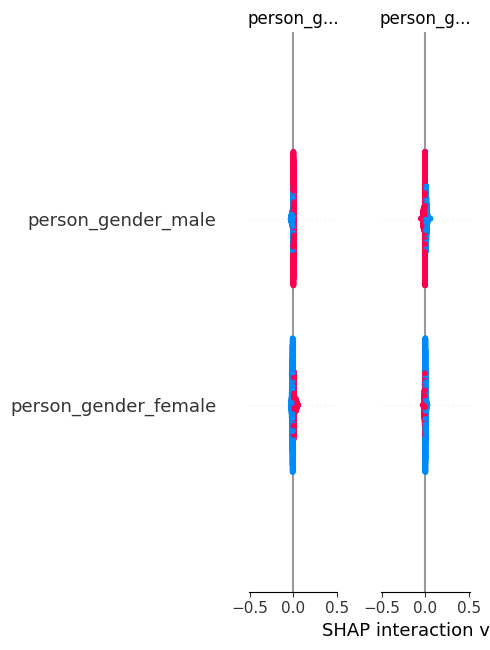

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve

# Re-import necessary libraries and re-run initial steps to define variables
# This assumes the dataset 'archive (3).zip' is available in /content/
# If not, please ensure it's uploaded or the path is correct.

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import shap

# 2) Load dataset (re-run)
try:
    df = pd.read_csv("/content/archive (3).zip")
except FileNotFoundError:
    print("Error: Dataset not found. Please upload 'archive (3).zip' to /content/ or update the path.")
    # Create dummy data for demonstration if file not found
    dummy_data_size = 1000
    df = pd.DataFrame({
        'feature_num_1': np.random.rand(dummy_data_size),
        'feature_num_2': np.random.rand(dummy_data_size),
        'feature_cat_1': np.random.choice(['A', 'B', 'C'], size=dummy_data_size),
        'loan_status': np.random.choice([0, 1], size=dummy_data_size, p=[0.7, 0.3])
    })

# 3) Features & Target (re-run)
X = df.drop("loan_status", axis=1)
y = df["loan_status"]

# 4) Identify categorical vs numerical (re-run)
cat_features = X.select_dtypes(include=['object']).columns.tolist()
num_features = X.select_dtypes(include=['int64','float64']).columns.tolist()

# 5) Preprocessing (re-run)
preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown='ignore'), cat_features),
    ("num", StandardScaler(), num_features)
])

# 6) Train-test split (re-run)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 7) SMOTE balancing (re-run)
smote = SMOTE(random_state=42)

# 8) Base models with SMOTE inside pipelines (re-run)
xgb_model = ImbPipeline([
    ("preprocess", preprocessor),
    ("smote", smote),
    ("xgb", XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        n_estimators=600,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.85,
        colsample_bytree=0.85,
        random_state=42
    ))
])

rf_model = ImbPipeline([
    ("preprocess", preprocessor),
    ("smote", smote),
    ("rf", RandomForestClassifier(
        n_estimators=600,
        random_state=42,
        class_weight="balanced"
    ))
])

lr_model = ImbPipeline([
    ("preprocess", preprocessor),
    ("smote", smote),
    ("lr", LogisticRegression(
        max_iter=5000,
        solver="saga",
        class_weight="balanced"
    ))
])

# 9) Stacking Ensemble (re-run)
stack_model = StackingClassifier(
    estimators=[
        ('xgb', xgb_model),
        ('rf', rf_model),
        ('lr', lr_model)
    ],
    final_estimator=LogisticRegression(max_iter=5000, solver="saga"),
    cv=5,
    stack_method="predict_proba"
)

# 10) Train stacking model (re-run)
stack_model.fit(X_train, y_train)

# 11) Evaluate - Get y_proba and y_pred (re-run)
y_proba = stack_model.predict_proba(X_test)[:,1]
threshold = 0.5
y_pred = (y_proba > threshold).astype(int)

# 12) SHAP Explainability for XGBoost - Get shap_values and X_test_transformed (re-run)
fitted_xgb_pipeline = stack_model.named_estimators_['xgb']
fitted_preprocessor = fitted_xgb_pipeline.named_steps['preprocess']

X_test_transformed = fitted_preprocessor.transform(X_test)

# Get feature names after preprocessing for SHAP plot
cat_ohe_feature_names = fitted_preprocessor.named_transformers_['cat'].get_feature_names_out(cat_features)
all_feature_names = np.concatenate([cat_ohe_feature_names, num_features])

# Create a SHAP explainer using the fitted XGBoost model's predict_proba and the transformed test set as masker
explainer = shap.Explainer(fitted_xgb_pipeline.named_steps['xgb'].predict_proba, masker=X_test_transformed)
shap_values = explainer(X_test_transformed)

# --- 1. Save Confusion Matrix ---
plt.figure(figsize=(7, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix: Loan Status Prediction')
plt.ylabel('Actual Status')
plt.xlabel('Predicted Status')
plt.savefig('confusion_matrix.png', dpi=300)
plt.show() # Added to display plot

# --- 2. Save ROC Curve ---
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC AUC = {auc(fpr, tpr):.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title('Receiver Operating Characteristic (ROC)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig('roc_curve.png', dpi=300)
plt.show() # Added to display plot

# --- 3. Fixed SHAP Plot Saving ---
plt.figure()
# Ensure shap_values has expected structure (e.g., from predict_proba for binary classification)
# If it's a list, take the first element for the positive class
if isinstance(shap_values, list):
    shap_summary_values = shap_values[1] # For the positive class (class 1)
else:
    shap_summary_values = shap_values

shap.summary_plot(shap_summary_values, X_test_transformed, feature_names=all_feature_names, show=False)
plt.tight_layout()
plt.savefig('shap_summary.png', bbox_inches='tight', dpi=300)
plt.show() # Added to display plot
